In [30]:
import sys
import os
sys.path = [os.path.abspath('../')] + sys.path

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
from pylab import rcParams
import numpy as np

from tick.hawkes import SimuHawkesExpKernels, HawkesKernelExp
from tick.hawkes import ModelHawkesExpKernLeastSq
from tick.solver import AGD, GFB
from tick.prox import ProxZero, ProxPositive, ProxL2Sq, ProxL1, ProxL1w, ProxNuclear
from scipy.misc import derivative

import scipy as sp
import scipy.stats

from scipy.optimize import minimize, fmin_l_bfgs_b
import os
import itertools
from multiprocessing import Pool, cpu_count
from sklearn.metrics import roc_auc_score
import time
import datetime

import traceback
from scipy.stats import kendalltau
from collections import OrderedDict
import pandas as pd
from scipy.interpolate import griddata
from collections import OrderedDict

import pickle
import re

%load_ext autoreload
%autoreload 2

import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
# os.environ['USE_THREAD'] = '0'
# os.environ['GOTO_NUM_THREADS'] = '1'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def dim_from_n(n):
    dim = int(round(0.5*(np.sqrt(1 + 4 * n) - 1)))
    return dim

def mus_alphas_from_coeffs(coeffs):
    n = coeffs.shape[0]
    dim = dim_from_n(n)
    mus = coeffs[0:dim]
    alphas = coeffs[dim:].reshape((dim, dim))
    return mus, alphas

def plot_coeffs(original_coeffs, coeffs=None):
    mus, alphas = mus_alphas_from_coeffs(original_coeffs)

    dim = mus.shape[0]
    if coeffs is None:
        n_plots = 1
        min_mu = np.min(mus)
        max_mu = np.max(mus)
        min_alpha = np.min(alphas)
        max_alpha = np.max(alphas)
    else:
        mus_, alphas_ = mus_alphas_from_coeffs(coeffs)
        min_mu = min(np.min(mus), np.min(mus_))
        max_mu = max(np.max(mus), np.max(mus_))
        min_alpha = min(np.min(alphas), np.min(alphas_))
        max_alpha = max(np.max(alphas), np.max(alphas_))
        n_plots = 3
    
    # Deal with mu
    rcParams['figure.figsize'] = 20, 1*n_plots
    ax_original = plt.subplot(n_plots, 1, 1)
    ax_original.matshow([mus], cmap='Blues', vmin=min_mu, vmax=max_mu)
    ax_original.set_ylabel('mu org')
    
    if coeffs is not None:
        mus_, alphas_ = mus_alphas_from_coeffs(coeffs)
        ax_estimated = plt.subplot(n_plots, 1, 2)
        ax_estimated.matshow([mus_], cmap='Blues', vmin=min_mu, vmax=max_mu)
        ax_estimated.set_ylabel('mu est')
        
        diff_matrix = mus_ - mus
        max_diff = np.max(np.abs(diff_matrix))
        ax_diff = plt.subplot(n_plots, 1, 3)
        im_diff = ax_diff.matshow([diff_matrix], cmap='bwr', vmin=-max_diff, vmax=max_diff)
        ax_diff.set_ylabel('mu diff')
        
    plt.show()
    
    # Deal with alpha
    rcParams['figure.figsize'] = 4*n_plots, 4
    ax_original = plt.subplot(1, n_plots, 1)
    ax_original.matshow(alphas, cmap='Blues', vmin=min_alpha, vmax=max_alpha)
    ax_original.set_xlabel('original alphas')
    
    if coeffs is not None:
        mus_, alphas_ = mus_alphas_from_coeffs(coeffs)
        ax_estimated = plt.subplot(1, n_plots, 2)
        ax_estimated.matshow(alphas_, cmap='Blues', vmin=min_alpha, vmax=max_alpha)
        ax_estimated.set_xlabel('estimated alphas')
        
        ax_diff = plt.subplot(1, n_plots, 3)
        diff_matrix = alphas_ - alphas
        max_diff = np.max(np.abs(diff_matrix))
        im_diff = ax_diff.matshow(diff_matrix, cmap='bwr', vmin=-max_diff, vmax=max_diff)
        ax_diff.set_xlabel('alphas diff')
        
        divider4 = make_axes_locatable(ax_diff)
        cax4 = divider4.append_axes("right", size="20%", pad=0.05)
        cbar4 = plt.colorbar(im_diff, cax=cax4)
        
    plt.show()

# Retrieve data

In [3]:
def load_coeffs(original_coeffs_path):
    if os.path.exists(original_coeffs_path):
        original_coeffs = np.load(original_coeffs_path)
        logger('found coeffs at %s' % original_coeffs_path)
    else:
        raise(FileNotFoundError('No coeffs found at %s' % original_coeffs_path))

    plot_coeffs(original_coeffs)
    return original_coeffs


def load_directory(directory, extension):
    if os.path.exists(directory):
        file_names = [filename for filename in os.listdir(directory) if filename.endswith(extension)]
        file_names.sort()
        return file_names
    else: raise(ValueError('Unexisting directory {}'.format(directory)))


def load_data(dim, run_time, n_models=30):
    train_directory = directory_prefix + 'train_hawkes/dim_%i/' % (dim)
    train_directory_pre_computed = train_directory + 'T_%0.f/pre_computed_contrast/' % (run_time)

    original_coeffs_path = os.path.join(train_directory, 'original_coeffs.npy')
    original_coeffs = load_coeffs(original_coeffs_path)
    
    model_file_names = load_directory(train_directory_pre_computed, 'pkl')
    logger('Retrieved %i precomputed models' % len(model_file_names))

    if len(model_file_names) > n_models:
        model_file_names = model_file_names[:n_models]
        logger('We keep %i precomputed models' % len(model_file_names))
    
    if len(model_file_names) < n_models:
        print(len(model_file_names))
    assert(len(model_file_names) >= n_models)
    
    model_file_paths = [os.path.join(train_directory_pre_computed, model_file_name) 
                       for model_file_name in model_file_names]
    return original_coeffs, model_file_paths


In [4]:
def plot_ticks_hist(ticks, title=''):
    n_ticks = [len(t) for t in ticks]
    rcParams['figure.figsize'] = 16, 3
    plt.step(np.arange(len(n_ticks)), n_ticks)
    plt.title(title)
    plt.xlabel('dimension')
    plt.ylabel('n jumps')
    plt.show()    

# Metrics

In [17]:
def estimation_error(coeffs, remove_diag=False):
    _, original_alphas = mus_alphas_from_coeffs(original_coeffs)
    _, alphas_ = mus_alphas_from_coeffs(coeffs.copy())
    dim = original_alphas.shape[0]
    
    original = original_alphas.reshape(dim*dim)
    estimated = alphas_.reshape(dim*dim)
    
    if remove_diag:
        original = remove_diag_flat_array(original, dim)
        estimated = remove_diag_flat_array(estimated, dim)
    
    return np.linalg.norm(original - estimated)**2 / np.linalg.norm(original)
    
def alphas_auc(coeffs, remove_diag=False):
    _, original_alphas = mus_alphas_from_coeffs(original_coeffs)
    dim = original_alphas.shape[0]
    
    non_zeros = original_alphas != 0
    labels = np.zeros_like(original_alphas)
    labels[non_zeros] = 1.
    
    _, alphas_ = mus_alphas_from_coeffs(coeffs.copy())
    alphas_ = (alphas_ - np.min(alphas_)) * (np.max(alphas_) - np.min(alphas_))
    
    # let's flatten this
    labels = labels.reshape(dim*dim)
    probas = alphas_.reshape(dim*dim)
    
    if remove_diag:
        labels = remove_diag_flat_array(labels, dim)
        probas = remove_diag_flat_array(probas, dim)
    
    return roc_auc_score(labels, probas)

def kendall(coeffs, remove_diag=False):
    _, original_alphas = mus_alphas_from_coeffs(original_coeffs)
    _, alphas_ = mus_alphas_from_coeffs(coeffs.copy())
    dim = original_alphas.shape[0]
    
    original = original_alphas.reshape(dim*dim)
    estimated = alphas_.reshape(dim*dim)
    
    if remove_diag:
        original = remove_diag_flat_array(original, dim)
        estimated = remove_diag_flat_array(estimated, dim)
        
    return kendalltau(original, estimated)[0]

def remove_diag_flat_array(arr, dim):
    arr = arr.copy()
    unused_value = -103901932
    arr[::dim + 1] = unused_value
    return arr[arr != unused_value]


dim = 3
original_coeffs = np.random.rand(dim + dim * dim)
original_coeffs[np.random.choice(np.arange(dim, dim + dim * dim), dim)] = 0
original_coeffs_bad_diag = original_coeffs.copy()
original_coeffs_bad_diag[dim: dim + 1] = 0

# alphas auc
assert alphas_auc(original_coeffs) == 1
assert alphas_auc(original_coeffs, remove_diag=True) == 1
assert alphas_auc(original_coeffs_bad_diag) < 1
assert alphas_auc(original_coeffs_bad_diag, remove_diag=True) == 1
# estimation error
assert estimation_error(original_coeffs) == 0
assert estimation_error(original_coeffs, remove_diag=True) == 0
assert estimation_error(original_coeffs_bad_diag) > 0
assert estimation_error(original_coeffs_bad_diag, remove_diag=True) == 0
# kendall
assert round(kendall(original_coeffs)) == 1
assert round(kendall(original_coeffs, remove_diag=True)) == 1
assert kendall(original_coeffs_bad_diag) < 1
assert round(kendall(original_coeffs_bad_diag, remove_diag=True)) == 1


metrics = OrderedDict()

metrics["alpha_auc"] = {'evaluator' : alphas_auc, 'best': 'max'}
metrics["alphas_auc_no_diag"] = {'evaluator' : lambda x: alphas_auc(x, remove_diag=True), 'best': 'max'}
metrics["estimation_error"] = {'evaluator' : estimation_error, 'best': 'min'}
metrics["estimation_error_no_diag"] = {'evaluator' : lambda x: estimation_error(x, remove_diag=True), 'best': 'min'}
metrics["kendall"] = {'evaluator' : kendall, 'best': 'max'}
metrics["kendall_no_diag"] = {'evaluator' : lambda x: kendall(x, remove_diag=True), 'best': 'max'}

# Crossfold

## Metrics utilities

In [6]:
def plot_with_errorbars(data_array, x_axis, ax, label='', loc='best', best='min'):
    """
    data_array is an array has on each line the value of the loss for one couple
    train_tick / test_ticks for all strength of strength range
    """
    mean, ci = mean_with_confidence_interval(data_array)
    
    if best == 'min':
        best_point = np.nanargmin(mean)
    elif best == 'max':
        best_point = np.nanargmax(mean)
        
    ax.axvline(x_axis[best_point], color='red', lw=3)
    ax.text(x_axis[best_point], min(mean), '%.3g\n%.3g +/- %.3g' % 
            (x_axis[best_point], mean[best_point], ci[best_point]), fontsize=16)
    
    n_samples = data_array.shape[0]
    ax.errorbar(x_axis, mean, yerr = ci, label=label)
    
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))
    ax.set_xscale('symlog', linthreshx=min(x_axis[x_axis != 0])*1e-2)


import math
def round_to_n(x, n=4):
    return round(x, -int(math.floor(math.log10(abs(x)))) + n - 1)

assert round_to_n(2.34398) == 2.344
assert round_to_n(2.34398e-5) == 2.344e-05
assert round_to_n(2.34398e-5, n=2) == 2.3e-05
    
def strength_range_from_infos(infos):
    strength_range = list(infos[0]['alpha_auc'].keys())
    # 2d case
    if isinstance(strength_range[0], tuple):
        pass
    else:
        strength_range = np.array(strength_range)
    strength_range.sort()
    return strength_range
    
def test_all_metrics(coeffs, info, strength):
    for metric, metric_info in metrics.items():
        evaluator = metric_info['evaluator']
        if metric not in info:
            info[metric] = {}
        info[metric][strength] = evaluator(coeffs)

def extract_metric(metric, infos, strength_range):
    strength_range = strength_range_from_infos(infos)
    return np.array([
                np.array([infos[i][metric][s] for s in strength_range]) 
            for i in range(len(model_file_names))])

def plot_all_metrics(infos, ax=None):
    strength_range = strength_range_from_infos(infos)
    if ax is None:
        n_plots = len(metrics.keys())
        fig, ax = plt.subplots(n_plots, 1, sharex=True)

    for i, metric in enumerate(metrics.keys()):
        metric_values = extract_metric(metric, infos, strength_range)
        plot_with_errorbars(metric_values, strength_range, ax[i], label=metric, loc='best', best=metrics[metric]['best'])
    
    # we return axes in case you want to modifify them afterwards
    return ax, fig

def mean_with_confidence_interval(data, confidence=0.95):
    data = 1.0*np.array(data)
    n = data.shape[0]
    nan_columns = np.isnan(data).any(axis=0)
    data = data[:, ~nan_columns]
    data_mean, data_se = np.mean(data, axis=0), scipy.stats.sem(data, axis=0, nan_policy='raise')
    tmp = np.zeros_like(nan_columns, dtype=np.float)
    tmp[nan_columns] = np.nan
    tmp[~nan_columns] = data_mean
    data_mean = tmp.copy()
    tmp[~nan_columns] = data_se
    data_se = tmp.copy()
    if len(data_mean) == 1:
        data_mean = data_mean[0]
        data_se = data_se[0]
    data_ci = data_se * sp.stats.t._ppf((1 + confidence) / 2., n - 1)
    return data_mean, data_ci

def format_strength(strength):
    if isinstance(strength, (int, float)):
        return '%.2g' % strength
    elif isinstance(strength, tuple):
        return str(tuple([format_strength(s) for s in strength]))

def print_all_metrics(infos, strength_range):
    for strength in strength_range:
        print('For value %s' % format_strength(strength))
        
        train_alphas_auc = extract_alpha_auc(infos, [strength])
        mean_auc, ci_auc = mean_with_confidence_interval(train_alphas_auc)
        print('mean auc  = %.6g (+/-%.4g)' % (mean_auc, ci_auc))
        
        train_alphas_auc_no_diag = extract_alpha_auc_no_diag(infos, [strength])
        mean_auc_no_diag, ci_auc_no_diag = mean_with_confidence_interval(train_alphas_auc_no_diag)
        print('mean auc no diag  = %.6g (+/-%.4g)' % (mean_auc_no_diag, ci_auc_no_diag))
        
        train_estimation_error = extract_estimation_error(infos, [strength])
        mean_error, ci_error = mean_with_confidence_interval(train_estimation_error)
        print('mean err  = %.6g (+/-%.4g)' % (mean_error, ci_error))
        

## Learn utilities

In [35]:
default_solver_kwargs = {
    'max_iter': 1500, 
    'verbose': False,
    'step': 1e4,
}        

n_used_cpu = 2# cpu_count() - 15


def extract_index(file_name, pattern, extension):
    regex = '%s_(\d+).%s' % (pattern, extension)
    match = re.search(regex, file_name)
    return match.group(1)


def learn(model_file_name, strength_range, tol, create_prox, 
          test_metrics, SolverClass, solver_kwargs, n_train=1):
    i = int(extract_index(model_file_name, 'precomputed', 'pkl'))
    with open(model_file_name, 'rb') as model_file:
        model_train = pickle.load(model_file)
        model_train.n_threads = 3
    
    # prepare infomartion store
    info = {}
    info['train_loss'] = {}
    
    for key in default_solver_kwargs.keys():
        if key not in solver_kwargs:
            solver_kwargs[key] = default_solver_kwargs[key]            
    solver_kwargs['tol'] = tol
    if SolverClass == AGD:
        solver_kwargs['linesearch'] = False
    solver_kwargs['step'] = 1./model_train.get_lip_best()
        
    for strength in strength_range:
        # Reinitialize problem (no warm start)
        coeffs = 1*np.ones(model_train.n_coeffs)
        solver = SolverClass(**solver_kwargs).set_model(model_train)
        
        # solve problem
        prox = create_prox(strength, model_train) # This function will set weights in case of ProxL1w
        solver.set_prox(prox)
        coeffs = solver.solve(coeffs)
        
        # warn if convergence was poor
        rel_objectives = solver.history.values['rel_obj']
        if len(rel_objectives) > 0:
            last_rel_obj = rel_objectives[-1]
            if (last_rel_obj > (tol * 1.1)):
                strength_txt = str(strength)
                logger('did not converge train=%i strength=%s, stopped at %.3g' % (i, strength, last_rel_obj))
        else:
            logger('failed for train=%i strength=%2.g, stopped at first iteration' % (i, strength))
        
        # record losses
        train_loss = model_train.loss(coeffs)
        info['train_loss'][strength] = train_loss
        
        # record test_metrics
        test_metrics(coeffs, info, strength)
        
    return i, info


def learn_in_parallel(strength_range, tol, create_prox, test_metrics=test_all_metrics,
                      SolverClass=AGD, solver_kwargs={}):
    start = time.time()
    n_train = len(model_file_names)
    
    args_list = model_file_names
    static_args = [strength_range, tol, create_prox, test_metrics, SolverClass, solver_kwargs, n_train]
    args_list = [[arg] + static_args for arg in args_list]    
    
    n_cpu = min(cpu_count(), len(model_file_names))
    pool = Pool(n_cpu)
    infos = None
    try:
        info_list = pool.starmap(learn, args_list)
        infos = {i:info for (i, info) in info_list}
        pool.close()
        pool.join()
    except Exception as e:
        traceback.print_exc()
        logger(traceback.format_exc())
    finally:
        pool.terminate()
    
    print('needed', time.time() - start, 'seconds')
    return infos



## Plot 2d utilities

In [8]:
def geometrical_center(axis_values):
    middle_values = [np.sqrt(l * u) for (l, u) in zip(axis_values[:-1], axis_values[1:])]
    first_value = axis_values[0]**2 / middle_values[0]
    last_value = axis_values[-1]**2 / middle_values[-1]
    axis_centered = [first_value] + middle_values + [last_value]
    return np.array(axis_centered)

def plot_2d_metric(infos, metric, ax=None):

    points = []
    z = []
    for k, v in infos[0][metric].items():
        points += [k]
        z += [v]

    points = np.array(points)
    z = np.array(z)

    grid = 50
    log_xi = np.linspace(-15, 5, grid)
    log_yi = np.linspace(-15, 5, grid)
    log_xi, log_yi = np.meshgrid(log_xi, log_yi)
    log_xi_flat = log_xi.reshape(grid*grid)
    log_yi_flat = log_yi.reshape(grid*grid)

    space = np.array([(xj, yj) for xj, yj in zip(log_xi_flat, log_yi_flat)])
    import scipy
    mytree = scipy.spatial.cKDTree(np.log10(points))
    dist_i, closest_i = mytree.query(space)
    zi = z[closest_i]
    # if the closest point is at more than a factor 10^2 we remove its value
    zi[dist_i > 2] = np.nan
    zi = zi.reshape((grid, grid))

    xi = np.power(10, log_xi)
    yi = np.power(10, log_yi)

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    #ax.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
    if metrics[metric]['best'] == 'min':
        cmap = 'Reds_r'
    elif metrics[metric]['best'] == 'max':
        cmap = 'Reds'
    CS = ax.contourf(xi, yi, zi, 15, cmap=cmap)
    #cbar = plt.colorbar(CS)
    ax.set_xscale('symlog', linthreshx=1e-15)
    ax.set_yscale('symlog', linthreshy=1e-15)
    ax.set_title(metric)
    

def plot_all_2d_metrics(infos):
    fig, ax = plt.subplots(2, 3)
    for i, metric in enumerate(metrics):
        plot_2d_metric(infos, metric, ax=ax[i//3][i%3])
    fig.tight_layout()
    return ax, fig


## Create prox functions

In [9]:

# L1
def create_prox_l1_no_mu(strength, model_train):
    dim = dim_from_n(model_train.n_coeffs)
    prox = ProxL1(strength, positive=True, range=(dim, dim*dim+dim))
    return prox

#def create_prox_l1(strength, model_train):
#    prox = ProxL1(strength, positive=True)
#    return prox

# L1 weighted
#def create_prox_l1w(strength, model):
#    weights = model.compute_penalization_constant()
#    prox = ProxL1w(strength, positive=True, weights=weights)
#    return prox

def create_prox_l1w_no_mu(strength, model):
    weights = model.compute_penalization_constant(strength=strength)
    dim = dim_from_n(model.n_coeffs)
    weights = weights[dim :]
    prox = ProxL1w(1, positive=True, weights=weights, range=(dim, dim*dim+dim))
    return prox

def create_prox_l1w_no_mu_un(strength, model):
    weights = model.compute_penalization_constant()
    dim = dim_from_n(model.n_coeffs)
    weights = weights[dim :]
    prox = ProxL1w(strength, positive=True, weights=weights, range=(dim, dim*dim+dim))
    return prox

def create_prox_l1w_simplified(strength, model):
    weights = model.compute_simplified_penalization_constant()
    dim = dim_from_n(model.n_coeffs)
    weights = weights[dim :]
    prox = ProxL1w(strength, positive=True, weights=weights, range=(dim, dim*dim+dim))
    return prox

def create_prox_l1w_simplified_no_B(strength, model):
    weights = model.compute_simplified_penalization_constant(with_B=False)
    dim = dim_from_n(model.n_coeffs)
    weights = weights[dim :]
    prox = ProxL1w(strength, positive=True, weights=weights, range=(dim, dim*dim+dim))
    return prox

# Nuclear
def create_prox_nuclear(strength, model):
    dim = dim_from_n(model.n_coeffs)
    prox_range = (dim, dim*dim + dim)
    n_rows = dim
    prox = ProxNuclear(strength, n_rows, range=prox_range, positive=True)
    return prox

#def create_prox_l1w_nuclear(strength, model):
#    l1, tau = strength
#    prox_l1 = create_prox_l1w(l1, model)
#    prox_nuclear = create_prox_nuclear(tau, model)
#    return (prox_l1, prox_nuclear, )


def create_prox_l1w_no_mu_nuclear(strength, model):
    l1, tau = strength
    prox_l1 = create_prox_l1w_no_mu(l1, model)
    prox_nuclear = create_prox_nuclear(tau, model)
    return (prox_l1, prox_nuclear, )


#def create_prox_l1_nuclear(strength, model):
#    l1, tau = strength
#    prox_l1 = create_prox_l1(l1, model)
#    prox_nuclear = create_prox_nuclear(tau, model)
#    return (prox_l1, prox_nuclear, )

def create_prox_l1_no_mu_nuclear(strength, model):
    l1, tau = strength
    prox_l1 = create_prox_l1_no_mu(l1, model)
    prox_nuclear = create_prox_nuclear(tau, model)
    return (prox_l1, prox_nuclear, )

# Prox reynaud
def create_prox_l1w_reynaud_no_mu(strength, model):
    weights = model.compute_reynaud_penalization_constant(strength=strength)
    dim = dim_from_n(model.n_coeffs)
    weights = weights[dim :]
    prox = ProxL1w(1., positive=True, weights=weights, range=(dim, dim*dim+dim))
    return prox


## Report utilities

In [10]:
import mistune
markdown = mistune.Markdown()

def logger(text):
    print(text)
    with open('report.html', 'a') as report_file:
        report_file.write(markdown(text))
    

import collections
def nested_update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.Mapping):
            r = nested_update(d.get(k, {}), v)
            d[k] = r
        else:
            d[k] = u[k]
    return d

def get_best_point(metric, infos, strength_range):
    metric_values = extract_metric(metric, infos, strength_range)
    mean, ic = mean_with_confidence_interval(metric_values)
    metric_info = metrics[metric]
    if metric_info['best'] == 'min':
        best_point = np.nanargmin(mean)
    elif metric_info['best'] == 'max':
        best_point = np.nanargmax(mean)
    return best_point

def get_new_range(infos, prox_name):
    strength_range = strength_range_from_infos(infos)
    
    current_min_range = min(strength_range[strength_range != 0])
    current_max_range = max(strength_range)
    
    new_strength_range = []
    for metric in metrics:
        best_point = get_best_point(metric, infos, strength_range)
        
        if best_point == 0 or (best_point == 1 and strength_range[0] == 0):
            if current_min_range > 1e-13:
                extension_point = current_min_range * 1e-3
                new_strength_range += list(np.logspace(np.log10(extension_point), np.log10(current_min_range), 4))
        
        elif best_point == len(strength_range) - 1:
            if current_max_range < 1e5:
                extension_point = current_max_range * 1e3
                new_strength_range += list(np.logspace(np.log10(current_max_range), np.log10(extension_point), 4))
                
        else:
            previous_best_strength = strength_range[best_point - 1]
            best_strength = strength_range[best_point]
            next_best_strength = strength_range[best_point + 1]
            
            # If we are not close enough from the best point
            if next_best_strength / previous_best_strength > prox_infos[prox_name]['max_relative_step']:            
                new_strength_range += [np.sqrt(previous_best_strength * best_strength)]
                new_strength_range += [np.sqrt(next_best_strength * best_strength)]
    
    new_strength_range = np.array(list(set(new_strength_range)))
    new_strength_range.sort()
    return new_strength_range

def create_if_missing(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

suffix = '2018_more_iterations'

def initialize_best_values():
    best_lambdas = pd.DataFrame(columns=['dim', 'prox', 'T', 'n_train'] + list(metrics.keys()))
    best_values_mean = pd.DataFrame(columns=['dim', 'prox', 'T', 'n_train'] + list(metrics.keys()))
    best_values_ic = pd.DataFrame(columns=['dim', 'prox', 'T', 'n_train'] + list(metrics.keys()))
    best_values_mean.to_csv("best_values_mean_%s.csv" % suffix, index=False)
    best_values_ic.to_csv("best_values_ic_%s.csv" % suffix, index=False)
    best_lambdas.to_csv("best_lambdas_%s.csv" % suffix, index=False)

    
def save_best_values(infos, dim, run_time, n_trains, prox_name):        

    best_values_mean = pd.read_csv("best_values_mean_%s.csv" % suffix)
    best_values_ic = pd.read_csv("best_values_ic_%s.csv" % suffix)
    best_lambdas = pd.read_csv("best_lambdas_%s.csv" % suffix)

    run_best_values_mean = {
        'dim': dim,
        'prox': prox_name,
        'T': run_time,
        'n_train': n_trains,
    }
    run_best_lambda = run_best_values_mean.copy()
    run_best_values_ic = run_best_values_mean.copy()

    for metric in metrics:
        strength_range = strength_range_from_infos(infos)
        metric_values = extract_metric(metric, infos, strength_range)
        mean_values, ic = mean_with_confidence_interval(metric_values)
        best_point = get_best_point(metric, infos, strength_range)

        run_best_values_mean[metric] = mean_values[best_point]
        run_best_values_ic[metric] = ic[best_point]
        run_best_lambda[metric] = strength_range[best_point]


    best_values_mean = best_values_mean.append(run_best_values_mean, ignore_index=True)
    best_values_ic = best_values_ic.append(run_best_values_ic, ignore_index=True)
    best_lambdas = best_lambdas.append(run_best_lambda, ignore_index=True)
        
    best_values_mean.to_csv("best_values_mean_%s.csv" % suffix, index=False)
    best_values_ic.to_csv("best_values_ic_%s.csv" % suffix, index=False)
    best_lambdas.to_csv("best_lambdas_%s.csv" % suffix, index=False)

In [11]:
# initialize_best_values()

In [12]:

# md stands for multiple dimensions
def get_new_range_md(infos, prox_name, extension_step=1e3, limit_low=1e-10, limit_high=1e2):
    
    def add_between(p1, p2, p_list):
        if max(p1 / p2, p2 / p1) > prox_infos[prox_name]['max_relative_step']:
            p_list += [np.sqrt(p1 * p2)]
    
    strength_range_md = strength_range_from_infos(infos)
    # number of parameters
    dim = len(strength_range_md[0])
    dims = range(dim)
    
    current_min_range = {}
    current_max_range = {}
    dim_strength_ranges = {}
    for d in dims:
        dim_strength_range = np.array(list(set([strength[d] for strength in strength_range_md])))
        dim_strength_range.sort()
        dim_strength_ranges[d] = dim_strength_range
        current_min_range[d] = min(dim_strength_range[dim_strength_range != 0])
        current_max_range[d] = max(dim_strength_range)
    
    new_strength_range = set()
    for metric in metrics:
        best_point = get_best_point(metric, infos, strength_range_md)
        best_point_md = {}
        for d in dims:
            dim_strength_range = dim_strength_ranges[d]
            dim_best_point = np.where(dim_strength_range == strength_range_md[best_point][d])[0][0]
            best_point_md[d] = dim_best_point
        
        best_point_types = {}
        for d in dims:
            dim_strength_range = dim_strength_ranges[d]
            dim_best_point = best_point_md[d]
            if dim_best_point == 0 or (dim_best_point == 1 and dim_strength_range[0] == 0):
                if current_min_range[d] > 1e-13:
                    best_point_types[d] = 'border low'
                else:
                    best_point_types[d] = 'limit low'
            elif dim_best_point == len(dim_strength_range) - 1:
                if current_max_range[d] < 1e5:
                    best_point_types[d] = 'border high'
                else:
                    best_point_types[d] = 'limit high'
            else:
                best_point_types[d] = 'inside'
            
        # extension style
        if np.any(np.array(['border' in best_point_types[d] for d in dims])):
            extension_points = {}
            for d in dims:
                dim_strength_range = dim_strength_ranges[d]
                dim_best_point = best_point_md[d]
                extension_points[d] = [dim_strength_range[dim_best_point]] #best
                if best_point_types[d] == 'border low':
                    extension_points[d] += [current_min_range[d] / extension_step] #smaller
                    extension_points[d] += [dim_strength_range[dim_best_point + 1]] #bigger
                elif best_point_types[d] == 'border high':
                    extension_points[d] += [dim_strength_range[dim_best_point - 1]] #smaller
                    extension_points[d] += [current_max_range[d] * extension_step] #bigger
                elif best_point_types[d] == 'limit low':
                    lowest_acceptable_point = min(dim_strength_range[dim_strength_range > limit_low])
                    extension_points[d] += [np.sqrt(limit_low * lowest_acceptable_point)]
                elif best_point_types[d] == 'limit high':
                    bigger_acceptable_point = max(dim_strength_range[dim_strength_range < limit_high])
                    extension_points[d] += [np.sqrt(limit_high * bigger_acceptable_point)]
                elif best_point_types[d] == 'inside':
                    extension_points[d] += [dim_strength_range[dim_best_point - 1]] #smaller
                    extension_points[d] += [dim_strength_range[dim_best_point + 1]] #bigger
                else:
                    raise(ValueError('Unknown type'))

            
            for new_point in itertools.product(*[extension_points[d] for d in dims]):
                if new_point not in infos[0]['alpha_auc']:
                    new_strength_range.add(new_point)
        # precision style
        else:
            precision_points = {}
            for d in dims:
                dim_strength_range = dim_strength_ranges[d]
                dim_best_point = best_point_md[d]
                precision_points[d] = [dim_strength_range[dim_best_point]] #best
                if best_point_types[d] == 'limit low':
                    lowest_acceptable_point = min(dim_strength_range[dim_strength_range > limit_low])
                    add_between(limit_low, lowest_acceptable_point, precision_points[d])
                elif best_point_types[d] == 'limit high':
                    bigger_acceptable_point = max(dim_strength_range[dim_strength_range < limit_high])
                    add_between(limit_low, bigger_acceptable_point, precision_points[d])
                elif best_point_types[d] == 'inside':
                    add_between(dim_strength_range[dim_best_point - 1], 
                                dim_strength_range[dim_best_point], precision_points[d]) # smaller
                    add_between(dim_strength_range[dim_best_point + 1], 
                                dim_strength_range[dim_best_point], precision_points[d]) # bigger
                else:
                    raise(ValueError('Unknown type'))
                    
            for new_point in itertools.product(*[precision_points[d] for d in dims]):
                if new_point not in infos[0]['alpha_auc']:
                    new_strength_range.add(new_point)
                    
            
    new_strength_range = list(new_strength_range)
    new_strength_range.sort()
    return new_strength_range
    

## Run experiments

In [28]:
prox_infos = OrderedDict()


"""
prox_infos['l1'] = {
    'n_initial_points': 10,
    'max_relative_step': 1.4,
    'create_prox': create_prox_l1_no_mu,
    'tol': 1e-10,
    'dim': 1,
}

prox_infos['l1 weigthed'] = {
    'n_initial_points': 10,
    'max_relative_step': 1.4,
    'create_prox': create_prox_l1w_no_mu,
    'tol': 1e-10,
    'dim': 1,
}
"""

"""
prox_infos['l1 weigthed no normalization'] = {
    'n_initial_points': 10,
    'max_relative_step': 1.4,
    'create_prox': create_prox_l1w_no_mu_un,
    'tol': 1e-10,
    'dim': 1,
}
"""
"""
prox_infos['l1 weigthed simplified'] = {
    'n_initial_points': 10,
    'max_relative_step': 1.4,
    'create_prox': create_prox_l1w_simplified,
    'tol': 1e-10,
    'dim': 1,
}

prox_infos['l1 weigthed no B'] = {
    'n_initial_points': 10,
    'max_relative_step': 1.4,
    'create_prox': create_prox_l1w_simplified_no_B,
    'tol': 1e-10,
    'dim': 1,
}

"""
"""
prox_infos['nuclear'] = {
    'n_initial_points': 10,
    'max_relative_step': 3,
    'create_prox': create_prox_nuclear,
    'tol': 1e-7,
    'dim': 1,
}

"""

prox_infos['l1 nuclear'] = {
    'n_initial_points': 10,
    'max_relative_step': 5,
    'create_prox': create_prox_l1_no_mu_nuclear,
    'tol': 1e-8,
    'dim': 2,
}

prox_infos['l1 weighted nuclear'] = {
    'n_initial_points': 10,
    'max_relative_step': 5,
    'create_prox': create_prox_l1w_no_mu_nuclear,
    'tol': 1e-8,
    'dim': 2,
}

list(prox_infos.keys())

['l1 nuclear', 'l1 weighted nuclear']

found coeffs at /Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/original_coeffs.npy


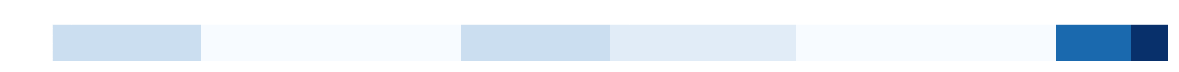

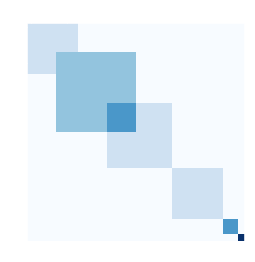

Retrieved 5 precomputed models
(<tick.prox.prox_l1.ProxL1 object at 0x114df5cc0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114cb8748>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


did not converge train=0 strength=(1e-05, 0.1), stopped at 0.0194
(<tick.prox.prox_l1.ProxL1 object at 0x114f34860>, <tick.prox.prox_nuclear.ProxNuclear object at 0x108fc4518>)
did not converge train=0 strength=(0.001, 0.1), stopped at 0.0227
(<tick.prox.prox_l1.ProxL1 object at 0x114f25a90>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114f25978>)


In [52]:
original_coeffs, model_file_names = load_data(30, 500, n_models=5)

def test():
    solver = GFB()
    prox_l1 = ProxL1(3.)
    prox_nuclear = ProxNuclear(2.)
    model = ModelHawkesExpKernLeastSq(3)
    model.fit([np.array([1, 2, 4.])])
    solver.set_model(model)
    solver.set_prox([prox_l1, prox_nuclear])
    
    model_file_name = model_file_names[0]
    strength_range = [(1e-5, 0.1), (1e-3, 0.1), (1e-1, 0.1)]
    tol = 1e-4
    create_prox = prox_infos['l1 nuclear']['create_prox']
    test_metrics = test_all_metrics
    SolverClass = GFB
    solver_kwargs = {'max_iter': 100}
    
    learn(model_file_name, strength_range, tol, create_prox, 
              test_metrics, SolverClass, solver_kwargs, n_train=1)
    
test()

# Dimension 30
## T= 500
found coeffs at /Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/original_coeffs.npy


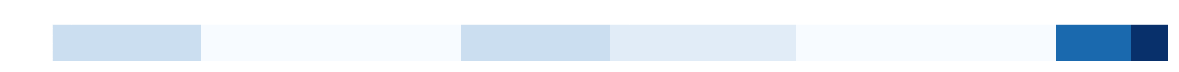

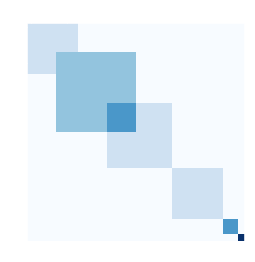

Retrieved 5 precomputed models
### For prox l1 nuclear
2018-10-22 17:27 Run 0 - With 9 new points


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1.ProxL1 object at 0x115c77ac8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77128>)
(<tick.prox.prox_l1.ProxL1 object at 0x114dccc18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1148236d8>)
(<tick.prox.prox_l1.ProxL1 object at 0x1148236d8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77ac8>)
(<tick.prox.prox_l1.ProxL1 object at 0x115c77978>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c775f8>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x115c77128>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77978>)
(<tick.prox.prox_l1.ProxL1 object at 0x115c775f8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77da0>)
(<tick.prox.prox_l1.ProxL1 object at 0x115c77b70>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11480e0f0>)
(<tick.prox.prox_l1.ProxL1 object at 0x115c77da0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77b70>)
(<tick.prox.prox_l1.ProxL1 object at 0x11480e470>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11448a978>)
(<tick.prox.prox_l1.ProxL1 object at 0x11480e0f0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11480e470>)
(<tick.prox.prox_l1.ProxL1 object at 0x115bfd358>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11448ad30>)
(<tick.prox.prox_l1.ProxL1 object at 0x1147c7898>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1147c7dd8>)
(<tick.prox.prox_l1.ProxL1 object at 0x114dea3c8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77a90>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1.ProxL1 object at 0x115c77358>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c771d0>)
(<tick.prox.prox_l1.ProxL1 object at 0x115c771d0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77080>)
(<tick.prox.prox_l1.ProxL1 object at 0x115c77080>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77a90>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x115c77a90>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77f28>)
(<tick.prox.prox_l1.ProxL1 object at 0x115c77f28>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11480e9e8>)
(<tick.prox.prox_l1.ProxL1 object at 0x114dea3c8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1147c7160>)
(<tick.prox.prox_l1.ProxL1 object at 0x11480e9e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11448a1d0>)
(<tick.prox.prox_l1.ProxL1 object at 0x11448a1d0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114dea3c8>)
(<tick.prox.prox_l1.ProxL1 object at 0x1147c7160>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5de48>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5de48>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d588>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5da58>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d828>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5de48>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d128>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x115c775f8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77da0>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x11480e0f0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11480e470>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x115c77b70>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11480e0f0>)
(<tick.prox.prox_l1.ProxL1 object at 0x115c77da0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77b70>)
(<tick.prox.prox_l1.ProxL1 object at 0x114dccc18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11448a978>)
(<tick.prox.prox_l1.ProxL1 object at 0x11448a978>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1147c7898>)
(<tick.prox.prox_l1.ProxL1 object at 0x1147c7668>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d128>)
(<tick.prox.prox_l1.ProxL1 object at 0x1147c7898>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1147c7668>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d9b0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d828>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d128>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d9b0>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d588>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d7b8>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1.ProxL1 object at 0x114dccc18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11480e630>)
(<tick.prox.prox_l1.ProxL1 object at 0x115c772b0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77f60>)
(<tick.prox.prox_l1.ProxL1 object at 0x114dccc18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1147c7dd8>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x11480e630>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11448ad30>)
(<tick.prox.prox_l1.ProxL1 object at 0x11448ad30>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115055c18>)
(<tick.prox.prox_l1.ProxL1 object at 0x1147c7dd8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d9e8>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5da58>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d7b8>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d9e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5da58>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d080>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d8d0>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d7b8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d080>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d828>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d0f0>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d4a8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d518>)
(

(<tick.prox.prox_l1.ProxL1 object at 0x114dccc18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c141d0>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c822e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c14e80>)
(<tick.prox.prox_l1.ProxL1 object at 0x11480e630>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d9e8>)
(<tick.prox.prox_l1.ProxL1 object at 0x11480e630>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c14438>)
(<tick.prox.prox_l1.ProxL1 object at 0x109c0ca90>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c77e80>)
(<tick.prox.prox_l1.ProxL1 object at 0x114dea3c8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5da90>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d828>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d0b8>)
(<tick.prox.prox_l1.ProxL1 object at 0x114a54cf8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114a54c88>)
(<tick.prox.prox_l1.ProxL1 object at 0x114f19c18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115c14908>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1.ProxL1 object at 0x114dccc18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1147c7160>)
(<tick.prox.prox_l1.ProxL1 object at 0x11480e9e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11448a1d0>)
(<tick.prox.prox_l1.ProxL1 object at 0x11448a1d0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114dea3c8>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5de48>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d588>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x1147c7160>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5de48>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d588>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d6d8>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5dcc0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d0f0>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d6d8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5dcc0>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d5f8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5dbe0>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d0f0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d5f8>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d8d0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5da58>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d4a8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d080>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c5d978>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114c5d7b8>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x115b50588>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718b38>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718b38>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718a58>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718a58>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718898>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718898>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1147187b8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11454f940>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115b50588>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718780>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718668>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718358>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718e48>)
(<tick.prox.prox_l1w.ProxL1w object at 0x1147186a0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718550>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114fe7240>, <tick.prox.prox_nuclear.ProxNuclear object 

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x114718c18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1147188d0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718e48>, <tick.prox.prox_nuclear.ProxNuclear object at 0x108903e80>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718550>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718e48>)
(<tick.prox.prox_l1w.ProxL1w object at 0x1147188d0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718668>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718668>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718550>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114fe7240>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4f8d0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fb70>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fbe0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fa20>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fa90>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4f8d0>, <tick.prox.prox_nuclear.ProxNuclear object 

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x114718080>, <tick.prox.prox_nuclear.ProxNuclear object at 0x108903cf8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x108903cf8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4f908>)
(<tick.prox.prox_l1w.ProxL1w object at 0x1147187b8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718390>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718390>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114718080>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4f908>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fa20>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4f9e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fa58>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fb38>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fba8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fa90>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fb00>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fc88>, <tick.prox.prox_nuclear.ProxNuclear object 

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x114d4f8d0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4f9e8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4f9e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fa90>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114718358>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1147181d0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fa90>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fb38>)
(<tick.prox.prox_l1w.ProxL1w object at 0x1147181d0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4f8d0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fb00>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fb70>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fc50>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fcc0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fba8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fc18>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fda0>, <tick.prox.prox_nuclear.ProxNuclear object 

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fb00>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fba8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fa58>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fb00>)
(<tick.prox.prox_l1w.ProxL1w object at 0x108903e80>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4f9b0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fba8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fc50>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4f9b0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fa58>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fc18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fc88>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fcc0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fd30>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4fd68>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114d4fdd8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114d4feb8>, <tick.prox.prox_nuclear.ProxNuclear object 

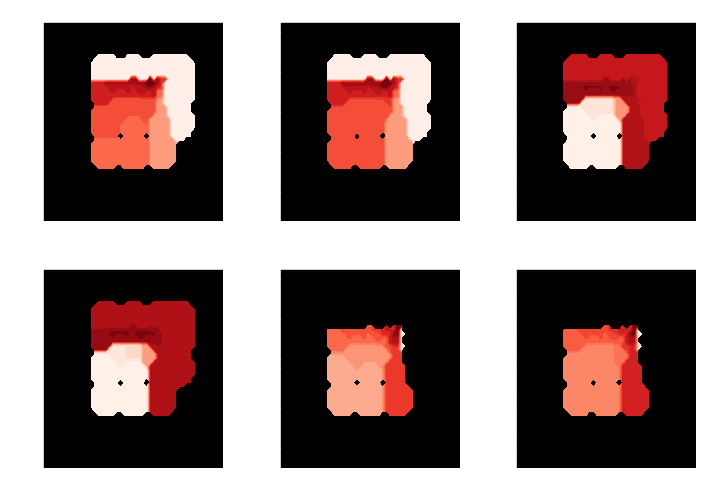

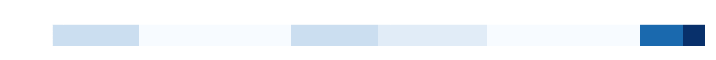

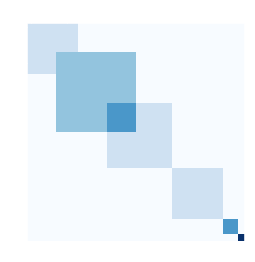

Retrieved 5 precomputed models
### For prox l1 nuclear
2018-10-22 17:30 Run 0 - With 9 new points


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1.ProxL1 object at 0x115970208>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115970358>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x115970358>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115970c88>)
(<tick.prox.prox_l1.ProxL1 object at 0x11593cc18>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114a94320>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x114a94320>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114fe70b8>)
(<tick.prox.prox_l1.ProxL1 object at 0x114fe70b8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115970208>)
(<tick.prox.prox_l1.ProxL1 object at 0x115970390>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115970c88>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c4e780>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115976e10>)
(<tick.prox.prox_l1.ProxL1 object at 0x1159760f0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115976a90>)
(<tick.prox.prox_l1.ProxL1 object at 0x115970d30>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115970ba8>)
(<tick.prox.prox_l1.ProxL1 object at 0x1159766d8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115976160>)
(<tick.prox.prox_l1.ProxL1 object at 0x1158fac88>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158fa828>)
(<tick.prox.prox_l1.ProxL1 object at 0x1159760b8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1159768d0>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1.ProxL1 object at 0x1159704e0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115970d68>)
(<tick.prox.prox_l1.ProxL1 object at 0x1159702e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115970518>)
(<tick.prox.prox_l1.ProxL1 object at 0x115976898>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1159760b8>)
(<tick.prox.prox_l1.ProxL1 object at 0x115970518>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1159704e0>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x115970d68>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115976898>)
(<tick.prox.prox_l1.ProxL1 object at 0x115976e10>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1159760b8>)
(<tick.prox.prox_l1.ProxL1 object at 0x115976a90>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1159768d0>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c4e780>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158fac88>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c4e780>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115479b00>)
(<tick.prox.prox_l1.ProxL1 object at 0x1158faa90>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158fa828>)
(<tick.prox.prox_l1.ProxL1 object at 0x1162ed438>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545c4a8>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545c4a8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545c080>)
(<tick.prox.prox_l1.ProxL1 object at 0x1162ed438>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545dc18>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x115976a90>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115976160>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x115976160>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158faa90>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x115970c88>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115970ba8>)
(<tick.prox.prox_l1.ProxL1 object at 0x115976e10>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115976a90>)
(<tick.prox.prox_l1.ProxL1 object at 0x115970ba8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115976e10>)
(<tick.prox.prox_l1.ProxL1 object at 0x1158fa518>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115479ba8>)
(<tick.prox.prox_l1.ProxL1 object at 0x1165e06d8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158faa90>)
(<tick.prox.prox_l1.ProxL1 object at 0x114c4e780>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545cf98>)
(<tick.prox.prox_l1.ProxL1 object at 0x1158fac88>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158faeb8>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545c080>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545d9e8>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545de80>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115978908>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1.ProxL1 object at 0x115976710>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1165e06d8>)
(<tick.prox.prox_l1.ProxL1 object at 0x1159760f0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1159766d8>)
(<tick.prox.prox_l1.ProxL1 object at 0x1165e06d8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158fa908>)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)


(<tick.prox.prox_l1.ProxL1 object at 0x1158fa908>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158fa518>)
(<tick.prox.prox_l1.ProxL1 object at 0x1159766d8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115976710>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545cf98>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545c080>)
(<tick.prox.prox_l1.ProxL1 object at 0x1158fac88>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158fa518>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545d9e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545dc18>)
(<tick.prox.prox_l1.ProxL1 object at 0x115479b00>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545c4a8>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545deb8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545dcf8>)
(<tick.prox.prox_l1.ProxL1 object at 0x1159783c8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115978e48>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545d400>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1148230f0>)
(

(<tick.prox.prox_l1.ProxL1 object at 0x115958da0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115958be0>)
(<tick.prox.prox_l1.ProxL1 object at 0x116396be0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115bbd9e8>)
(<tick.prox.prox_l1.ProxL1 object at 0x115bbde10>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115bb8d68>)
(<tick.prox.prox_l1.ProxL1 object at 0x115bb8fd0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115bb8f28>)
(<tick.prox.prox_l1.ProxL1 object at 0x115bbdb70>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115bbd978>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545de80>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115958d68>)
(<tick.prox.prox_l1.ProxL1 object at 0x115b009e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115bbdfd0>)
(<tick.prox.prox_l1.ProxL1 object at 0x116396be0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115bbdba8>)
(<tick.prox.prox_l1.ProxL1 object at 0x115bb8e10>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115bb8e48>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1.ProxL1 object at 0x1159768d0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158fac88>)
(<tick.prox.prox_l1.ProxL1 object at 0x1159760b8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1159768d0>)
(<tick.prox.prox_l1.ProxL1 object at 0x115479b00>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545ccc0>)
(<tick.prox.prox_l1.ProxL1 object at 0x1158fa828>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115479b00>)
(<tick.prox.prox_l1.ProxL1 object at 0x1158fac88>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1158fa828>)
(<tick.prox.prox_l1.ProxL1 object at 0x1148230f0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115978908>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545d9e8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545de80>)
(<tick.prox.prox_l1.ProxL1 object at 0x11545c4a8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11545ccc0>)
(<tick.prox.prox_l1.ProxL1 object at 0x115978208>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115978be0>)
(

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x116743f60>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115a806a0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114fe5470>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114fe5828>)
(<tick.prox.prox_l1w.ProxL1w object at 0x115a806a0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x114fe5470>)
(<tick.prox.prox_l1w.ProxL1w object at 0x1149609b0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507f6d8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114fe5828>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1149609b0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x114fe5ac8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507fc88>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507fe80>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507fef0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507f748>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507f080>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507f2b0>, <tick.prox.prox_nuclear.ProxNuclear object 

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x114fe5748>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507f160>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507f748>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507fe80>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507f160>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507f748>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507fe80>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507f2b0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507f2b0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11506e080>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11506e390>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309eb8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507f940>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309cc0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309cf8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1163090b8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11506eb38>, <tick.prox.prox_nuclear.ProxNuclear object 

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x11507f6d8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507fc88>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507fef0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11506e390>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507f080>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507fef0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11506e390>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309dd8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507fc88>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507f080>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309eb8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309828>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11506eb38>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309390>)
(<tick.prox.prox_l1w.ProxL1w object at 0x1163090b8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309fd0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309e48>, <tick.prox.prox_nuclear.ProxNuclear object 

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x11507f320>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11507f940>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11507f940>, <tick.prox.prox_nuclear.ProxNuclear object at 0x11506eb38>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309b70>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309cf8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309cf8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309f60>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11506eb38>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309b70>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309828>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1163096a0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309390>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309e80>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309fd0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309e10>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309320>, <tick.prox.prox_nuclear.ProxNuclear object 

(<tick.prox.prox_l1w.ProxL1w object at 0x116309240>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1163091d0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309198>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115a30e48>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309cf8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309550>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309518>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1163090b8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x115a303c8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115a30d68>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309898>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115a309b0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x115a307b8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115a30c18>)
(<tick.prox.prox_l1w.ProxL1w object at 0x115a301d0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x115a30b70>)
(<tick.prox.prox_l1w.ProxL1w object at 0x115a30358>, <tick.prox.prox_nuclear.ProxNuclear object 

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function svds is deprecated; sklearn.utils.arpack.svds was deprecated in version 0.19 and will be removed in 0.21. Use scipy.sparse.linalg.svds instead.
  warnings.warn(ms

(<tick.prox.prox_l1w.ProxL1w object at 0x116309e48>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309eb8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309cc0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309e48>)
(<tick.prox.prox_l1w.ProxL1w object at 0x1163090b8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309518>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309eb8>, <tick.prox.prox_nuclear.ProxNuclear object at 0x1163090b8>)
(<tick.prox.prox_l1w.ProxL1w object at 0x11506e080>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309cc0>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309e80>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309b00>)
(<tick.prox.prox_l1w.ProxL1w object at 0x1163096a0>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309198>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309e10>, <tick.prox.prox_nuclear.ProxNuclear object at 0x116309358>)
(<tick.prox.prox_l1w.ProxL1w object at 0x116309c88>, <tick.prox.prox_nuclear.ProxNuclear object 

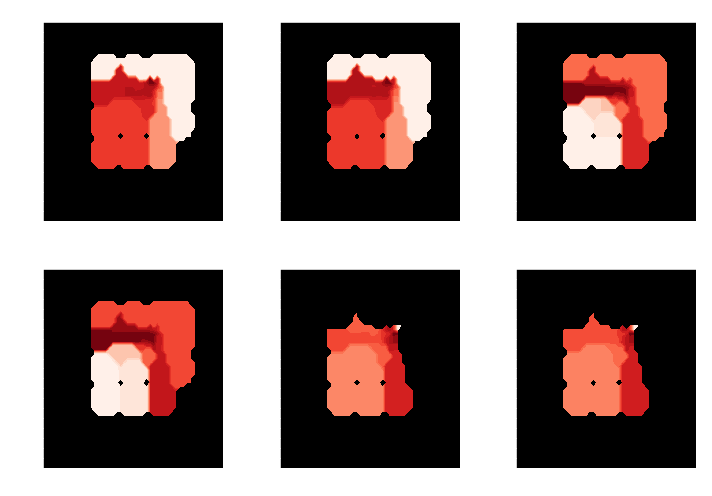

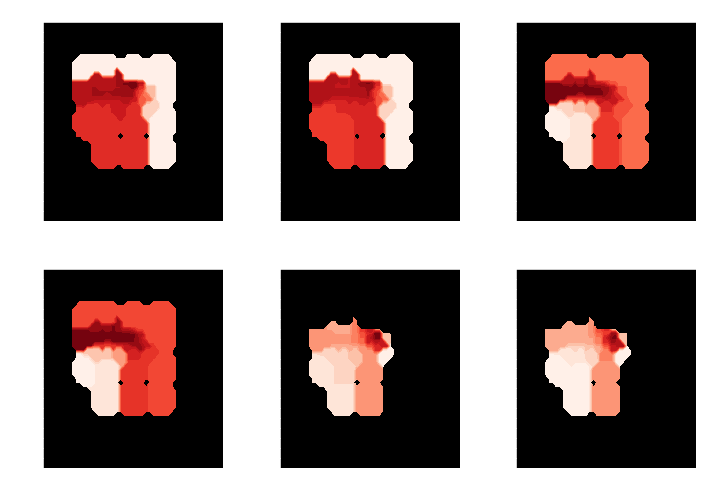

In [53]:
dims = [30]
run_times = [500, 1000]#, 2000, 5000, 7000, 10000, 15000, 20000]
# run_times = [15000, 20000]
n_models = 5
beta = 1.

directory_prefix = '/Users/martin/Downloads/jmlr_hawkes_data/'
# directory_prefix = '/data/data/public/jmlr_hawkes_data/'

#initialize_best_values()

for dim in dims:
    logger('# Dimension %i' % dim)
    for run_time in run_times:
        logger('## T= %i' % run_time)
        original_coeffs, model_file_names = load_data(dim, run_time, n_models=n_models)
        for prox_name, prox_info in prox_infos.items():
            logger('### For prox %s' % prox_name)
            
            # create images directory
            rcParams['figure.figsize'] = 10, 7
            dir_name = 'dim_%i/T_%i/prox_%s' % (dim, run_time, prox_name)
            create_if_missing(dir_name)

            tol = prox_info['tol']
            
            if prox_info['dim'] == 1:
                run_strength_range = np.hstack((0, np.logspace(-7, 2, prox_info['n_initial_points'])))
            elif prox_info['dim'] == 2:
                toy_strength_range_1 = np.logspace(-8, -2, 3)
                toy_strength_range_2 = np.logspace(-8, -2, 3)
                run_strength_range = [(l1, tau) for (l1, tau) 
                                      in itertools.product(toy_strength_range_1, toy_strength_range_2)]
            run_infos = {}
            
            for run_count in range(10):
                logger('%s Run %i - With %i new points' % (
                        datetime.datetime.today().strftime('%Y-%m-%d %H:%M'), run_count, len(run_strength_range)))
                old_run_infos = run_infos
                
                if prox_info['dim'] == 1:
                    run_infos = learn_in_parallel(run_strength_range, tol, 
                                                  prox_info['create_prox'], test_all_metrics)
                elif prox_info['dim'] == 2:
                    solver_kwargs = {
                    'max_iter': 10000,
                    }
                    run_infos = learn_in_parallel(run_strength_range, tol, 
                                                  prox_info['create_prox'], test_all_metrics,
                                                  SolverClass=GFB, solver_kwargs=solver_kwargs)
                run_infos = nested_update(run_infos, old_run_infos)
                
                if prox_info['dim'] == 1:
                    run_strength_range = get_new_range(run_infos, prox_name)
                elif prox_info['dim'] == 2:    
                    run_strength_range = get_new_range_md(run_infos, prox_name, extension_step=1e2)
                if len(run_strength_range) == 0:
                    break
                     
            if prox_info['dim'] == 1:
                ax, fig = plot_all_metrics(run_infos)
            elif prox_info['dim'] == 2:
                ax, fig = plot_all_2d_metrics(run_infos)
            graph_file_path = os.path.join(dir_name, 'run_%i_%i.png' % (run_count, int(time.time())))
            fig.savefig(graph_file_path, dpi=100, format='png', bbox_inches='tight')
            logger('![alt text](%s "Title")' % graph_file_path)
            
            save_best_values(run_infos, dim, run_time, len(model_file_names), prox_name)


found coeffs at /data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/original_coeffs.npy


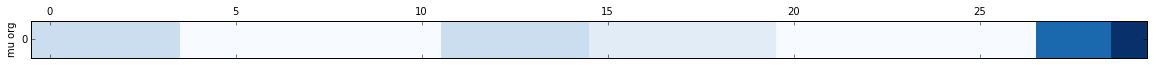

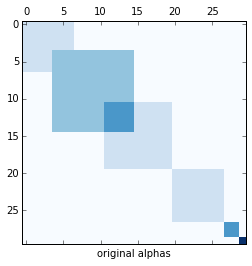

Retrieved 100 precomputed models
We keep 30 precomputed models


['/data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_000.pkl',
 '/data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_001.pkl',
 '/data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_002.pkl',
 '/data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_003.pkl',
 '/data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_004.pkl',
 '/data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_005.pkl',
 '/data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_006.pkl',
 '/data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_007.pkl',
 '/data/data/public/jmlr_hawkes_data/train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_008.pkl',
 '/data/data/public/jmlr_hawkes_data/

# Toy example

In [ ]:
def toy_auc(x):
    if x == 0: return toy_auc(1e-11)
    if x > 1e-1: return toy_auc(1e-1)
    return 0.5 - 0.1 * np.arctan( 5 * np.log10(x/1e-3) )
"""
#toy_auc = np.vectorize(toy_auc)
xaxis = np.hstack((0, np.logspace(-9, 4)))
yaxis = toy_auc(xaxis)
ax = plt.subplot(211)
ax.plot(xaxis, yaxis)
ax.set_xscale('symlog', linthreshx = 1e-10)
ax.set_title('toy_auc')
"""
def toy_kendall(x):
    if x == 0: return toy_kendall(1e-100)
    return np.cos(np.log10(x/1e-3)) * np.exp(- 3 * np.abs(np.log10(x/1e-3)))

def toy_kendall_no_diag(x):
    if x > 1e-1:
        return np.nan
    return toy_kendall(x*1e3)

"""
toy_kendall = np.vectorize(toy_kendall)

xaxis = np.hstack((0, np.logspace(-9, 4)))
yaxis = toy_kendall(xaxis)
ax = plt.subplot(212)
ax.plot(xaxis, yaxis)
ax.set_xscale('symlog', linthreshx = 1e-10)
ax.set_title('toy_kendall')
"""

toy_estimation_error = toy_auc

#plt.tight_layout()

In [ ]:
match_metric_function = {
        'alpha_auc': toy_auc,
        'alphas_auc_no_diag': toy_auc,
        'estimation_error': toy_auc,
        'estimation_error_no_diag': toy_auc,
        'kendall': toy_kendall,
        'kendall_no_diag': toy_kendall_no_diag,
    }

def toy_learn(toy_strength_range):
    toy_infos = {}
    for metric in metrics:
        for i in range(len(train_ticks)):
            if i not in toy_infos:
                toy_infos[i] = {}
            metric_values = {strength: match_metric_function[metric](strength) + np.random.uniform(-0.0001, 0.0001)
                             for strength in toy_strength_range}
            toy_infos[i][metric] = metric_values
    return toy_infos

In [ ]:

    
train_ticks = [0 for _ in range(10)]
toy_strength_range = np.hstack((0, np.logspace(-5, -2, 10)))
toy_infos = {}

rcParams['figure.figsize'] = 16, 5
for run_count in range(10):
    print('Run %i' % (run_count))
    
    old_toy_infos = toy_infos
    toy_infos = toy_learn(toy_strength_range)
    toy_infos = nested_update(toy_infos, old_toy_infos)
    toy_strength_range = get_new_range(toy_infos, 'l1')
    if len(toy_strength_range) == 0:
        break

plot_all_metrics(toy_infos)

In [ ]:
def to2d(f1, f2=None):
    if f2 is None: 
        f2 = f1
    return lambda x, y : f1(x) + f2(y)

"""
match_metric_function_2d = {
    'alpha_auc': to2d(toy_auc, toy_kendall),
    'alphas_auc_no_diag': to2d(toy_kendall, toy_auc),
    'estimation_error': to2d(toy_auc),
    'estimation_error_no_diag': to2d(toy_auc),
    'kendall': to2d(toy_kendall),
    'kendall_no_diag': to2d(toy_kendall, toy_kendall_no_diag),
}

"""
unique_toy = to2d(toy_auc, toy_kendall)
match_metric_function_2d = {
    'alpha_auc': unique_toy,
    'alphas_auc_no_diag': unique_toy,
    'estimation_error': unique_toy,
    'estimation_error_no_diag': unique_toy,
    'kendall': unique_toy,
    'kendall_no_diag': unique_toy,
}



def toy_learn2d(toy_strength_range):
    toy_infos = {}
    for metric in metrics:
        for i in range(len(train_ticks)):
            if i not in toy_infos:
                toy_infos[i] = {}
            metric_values = {strength: match_metric_function_2d[metric](*strength) + np.random.uniform(-0.0001, 0.0001)
                             for strength in toy_strength_range}
            toy_infos[i][metric] = metric_values
    return toy_infos


In [ ]:

    
#rcParams['figure.figsize'] = 8, 6
#metric = 'kendall_no_diag'
#metric_values = extract_metric(metric, toy_infos_2d, toy_strength_range_l1_nuclear)
#plot_2d_metric(metric_values, toy_infos_2d, toy_strength_range_1, toy_strength_range_2, metric, best=metrics[metric]['best'])

In [ ]:
train_ticks = [0 for _ in range(10)]
toy_strength_range_1 = np.logspace(-8, -2, 3)
toy_strength_range_2 = np.logspace(-8, -2, 3)
toy_infos_2d = {}

toy_strength_range_l1_nuclear = [(l1, tau) for (l1, tau) in itertools.product(toy_strength_range_1, toy_strength_range_2)]

for run_count in range(5):
    
    old_toy_infos_2d = toy_infos_2d
    toy_infos_2d = toy_learn2d(toy_strength_range_l1_nuclear)
    toy_infos_2d = nested_update(toy_infos_2d, old_toy_infos_2d)
    plot_2d_metric(toy_infos_2d, 'alpha_auc')
    plt.show()
    print('Run %i' % (run_count))
    toy_strength_range_l1_nuclear = get_new_range_md(toy_infos_2d, 'l1 nuclear', extension_step=1e2)
    print(len(toy_strength_range_l1_nuclear))
    if len(toy_strength_range_l1_nuclear) == 0:
        break

with_plot = False
if with_plot:
    fig, ax = plt.subplots(2, 3)
    for i, metric in enumerate(metrics):
        plot_2d_metric(toy_infos_2d, metric, ax=ax[i//3][i%3])
    fig.tight_layout()
    
else:
    plot_2d_metric(toy_infos_2d, 'alpha_auc')
    plt.show()

In [ ]:
save_best_values(toy_infos_2d, 3, 10, 'l1 nuclear')       


In [ ]:

# md stands for multiple dimensions
def get_new_range_md(infos, prox_name, extension_step=1e3, limit_low=1e-10, limit_high=1e2):
    
    def add_between(p1, p2, p_list):
        if max(p1 / p2, p2 / p1) > prox_infos[prox_name]['max_relative_step']:
            p_list += [np.sqrt(p1 * p2)]
    
    strength_range_md = strength_range_from_infos(infos)
    # number of parameters
    dim = len(strength_range_md[0])
    dims = range(dim)
    
    current_min_range = {}
    current_max_range = {}
    dim_strength_ranges = {}
    for d in dims:
        dim_strength_range = np.array(list(set([strength[d] for strength in strength_range_md])))
        dim_strength_range.sort()
        dim_strength_ranges[d] = dim_strength_range
        current_min_range[d] = min(dim_strength_range[dim_strength_range != 0])
        current_max_range[d] = max(dim_strength_range)
    
    new_strength_range = set()
    for metric in metrics:
        best_point = get_best_point(metric, infos, strength_range_md)
        best_point_md = {}
        for d in dims:
            dim_strength_range = dim_strength_ranges[d]
            dim_best_point = np.where(dim_strength_range == strength_range_md[best_point][d])[0][0]
            best_point_md[d] = dim_best_point
        
        best_point_types = {}
        for d in dims:
            dim_strength_range = dim_strength_ranges[d]
            dim_best_point = best_point_md[d]
            if dim_best_point == 0 or (dim_best_point == 1 and dim_strength_range[0] == 0):
                if current_min_range[d] > 1e-13:
                    best_point_types[d] = 'border low'
                else:
                    best_point_types[d] = 'limit low'
            elif dim_best_point == len(dim_strength_range) - 1:
                if current_max_range[d] < 1e5:
                    best_point_types[d] = 'border high'
                else:
                    best_point_types[d] = 'limit high'
            else:
                best_point_types[d] = 'inside'
            
        # extension style
        if np.any(np.array(['border' in best_point_types[d] for d in dims])):
            extension_points = {}
            for d in dims:
                dim_strength_range = dim_strength_ranges[d]
                dim_best_point = best_point_md[d]
                extension_points[d] = [dim_strength_range[dim_best_point]] #best
                if best_point_types[d] == 'border low':
                    extension_points[d] += [current_min_range[d] / extension_step] #smaller
                    extension_points[d] += [dim_strength_range[dim_best_point + 1]] #bigger
                elif best_point_types[d] == 'border high':
                    extension_points[d] += [dim_strength_range[dim_best_point - 1]] #smaller
                    extension_points[d] += [current_max_range[d] * extension_step] #bigger
                elif best_point_types[d] == 'limit low':
                    lowest_acceptable_point = min(dim_strength_range[dim_strength_range > limit_low])
                    extension_points[d] += [np.sqrt(limit_low * lowest_acceptable_point)]
                elif best_point_types[d] == 'limit high':
                    bigger_acceptable_point = max(dim_strength_range[dim_strength_range < limit_high])
                    extension_points[d] += [np.sqrt(limit_high * bigger_acceptable_point)]
                elif best_point_types[d] == 'inside':
                    extension_points[d] += [dim_strength_range[dim_best_point - 1]] #smaller
                    extension_points[d] += [dim_strength_range[dim_best_point + 1]] #bigger
                else:
                    raise(ValueError('Unknown type'))

            
            for new_point in itertools.product(*[extension_points[d] for d in dims]):
                if new_point not in infos[0]['alpha_auc']:
                    new_strength_range.add(new_point)
        # precision style
        else:
            precision_points = {}
            for d in dims:
                dim_strength_range = dim_strength_ranges[d]
                dim_best_point = best_point_md[d]
                precision_points[d] = [dim_strength_range[dim_best_point]] #best
                if best_point_types[d] == 'limit low':
                    lowest_acceptable_point = min(dim_strength_range[dim_strength_range > limit_low])
                    add_between(limit_low, lowest_acceptable_point, precision_points[d])
                elif best_point_types[d] == 'limit high':
                    bigger_acceptable_point = max(dim_strength_range[dim_strength_range < limit_high])
                    add_between(limit_low, bigger_acceptable_point, precision_points[d])
                elif best_point_types[d] == 'inside':
                    add_between(dim_strength_range[dim_best_point - 1], 
                                dim_strength_range[dim_best_point], precision_points[d]) # smaller
                    add_between(dim_strength_range[dim_best_point + 1], 
                                dim_strength_range[dim_best_point], precision_points[d]) # bigger
                else:
                    raise(ValueError('Unknown type'))
                    
            for new_point in itertools.product(*[precision_points[d] for d in dims]):
                if new_point not in infos[0]['alpha_auc']:
                    new_strength_range.add(new_point)
                    
            
    new_strength_range = list(new_strength_range)
    new_strength_range.sort()
    return new_strength_range
    

In [ ]:
sample_size = 10
data = list(np.random.normal(size=(sample_size, 2)))

mean_with_confidence_interval(data)

In [ ]:
len(data)